In [2]:
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

Ori_df = pd.read_csv('C:/Users/houju/Desktop/Data_Analysis_SelfLearn/Clustering_DataCamp_Self/Clustering_Ontario_Project/ontario_builds_cleaned.csv')
print(f"Total rows: {len(Ori_df)}")
# Status distribution
print("📊 Status Value Counts:")
print(Ori_df['Status'].value_counts(dropna=False))

# Category distribution
print("\n📊 Category Value Counts:")
print(Ori_df['Category'].value_counts(dropna=False))

Total rows: 3453
📊 Status Value Counts:
Status
Complete              3075
Under construction     216
Planning               162
Name: count, dtype: int64

📊 Category Value Counts:
Category
Communities          1842
Education             679
Child care            302
Roads and bridges     274
Transit               154
Recreation            120
Health care            82
Name: count, dtype: int64


In [2]:
Ori_df.head()

_id     Category                  Community    Status   
0    2  Communities                   Brampton  Complete  \
1    9  Communities                    Toronto  Complete   
2   10  Communities                    Toronto  Complete   
3   11  Communities                       Ajax  Complete   
4   12  Communities  Attawapiskat First Nation  Complete   

  Target Completion Date     Area     Region  Estimated Total Budget ($)   
0             2024-12-23     Peel    Central                    82500000  \
1             2024-01-23  Toronto    Central                   956400000   
2             2024-12-22  Toronto    Central                    82500000   
3             2024-10-24   Durham    Central                    31000000   
4             2024-04-18   Kenora  Northwest                     1200000   

    Latitude  Longitude Raw Completion Date  Municipal Funding_Flag   
0  43.661701 -79.726047              23-Dec                       0  \
1  43.653618 -79.386200              23-Jan                       0   
2  43.752606 -79.536505              22-Dec                       0   
3  43.879000 -79.030000              24-Oct                       0   
4  52.550000 -82.260000              18-Apr                       0   

   Provincial Funding_Flag  Federal Funding_Flag  Other Funding_Flag  
0                        1                     0                   0  
1                        1                     0                   0  
2                        1                     0                   0  
3                        1                     1                   1  
4                        1                     0                   0

In [3]:
Ori_df['Target Completion Date'] = pd.to_datetime(Ori_df['Target Completion Date'])
# Extract year as a new column from Target Completion Date
Ori_df['Completion_Year'] = Ori_df['Target Completion Date'].dt.year

# Ignore Recreation category first
Ori_df['Category'] = pd.Categorical(Ori_df['Category'], categories=['Recreation', 'Communities', 'Education', 'Child care', 'Roads and bridges', 
                                                      'Transit', 'Health care'])
df_dummy = pd.get_dummies(Ori_df[[
    'Latitude', 'Longitude',
    'Estimated Total Budget ($)',
    'Completion_Year',
    'Status', 'Category',
    'Provincial Funding_Flag',
    'Federal Funding_Flag',
    'Municipal Funding_Flag',
    'Other Funding_Flag',
]], columns=['Status', 'Category'], drop_first=True)
df_dummy.head()

Latitude  Longitude  Estimated Total Budget ($)  Completion_Year   
0  43.661701 -79.726047                    82500000             2024  \
1  43.653618 -79.386200                   956400000             2024   
2  43.752606 -79.536505                    82500000             2024   
3  43.879000 -79.030000                    31000000             2024   
4  52.550000 -82.260000                     1200000             2024   

   Provincial Funding_Flag  Federal Funding_Flag  Municipal Funding_Flag   
0                        1                     0                       0  \
1                        1                     0                       0   
2                        1                     0                       0   
3                        1                     1                       0   
4                        1                     0                       0   

   Other Funding_Flag  Status_Planning  Status_Under construction   
0                   0            False                      False  \
1                   0            False                      False   
2                   0            False                      False   
3                   1            False                      False   
4                   0            False                      False   

   Category_Communities  Category_Education  Category_Child care   
0                  True               False                False  \
1                  True               False                False   
2                  True               False                False   
3                  True               False                False   
4                  True               False                False   

   Category_Roads and bridges  Category_Transit  Category_Health care  
0                       False             False                 False  
1                       False             False                 False  
2                       False             False                 False  
3                       False             False                 False  
4                       False             False                 False

In [4]:
# Select features to scale
features_to_scale = ['Estimated Total Budget ($)', 'Completion_Year']
df_scaled = df_dummy.copy()
df_scaled[features_to_scale] = StandardScaler().fit_transform(df_dummy[features_to_scale])
# Select columns (excluding lat/lon for multi-feature clustering)
df_noloc = df_scaled.drop(['Latitude', 'Longitude'], axis=1)

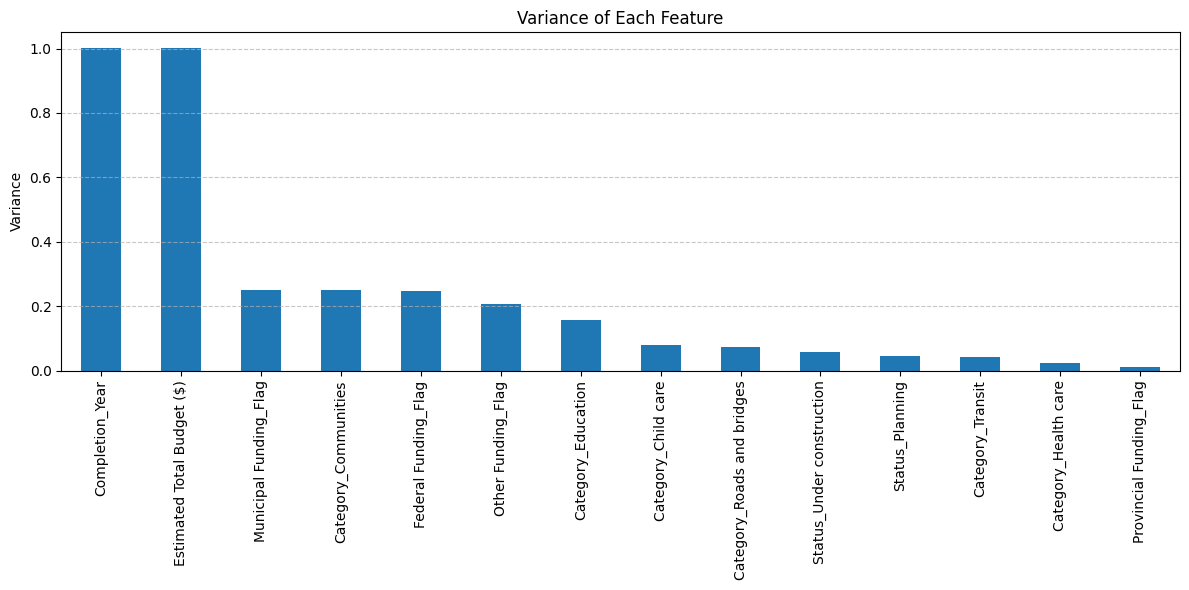

Completion_Year               1.000290
Estimated Total Budget ($)    1.000290
Municipal Funding_Flag        0.249690
Category_Communities          0.248953
Federal Funding_Flag          0.247719
Other Funding_Flag            0.206763
Category_Education            0.158019
Category_Child care           0.079834
Category_Roads and bridges    0.073076
Status_Under construction     0.058658
Status_Planning               0.044728
Category_Transit              0.042622
Category_Health care          0.023190
Provincial Funding_Flag       0.010887
dtype: float64


In [5]:

# Calculate variance for each feature
feature_variances = df_noloc.var().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
feature_variances.plot(kind='bar')
plt.title('Variance of Each Feature')
plt.ylabel('Variance')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print(feature_variances)
# df_noloc = df_noloc.drop(['Provincial Funding_Flag','Category_Child care','Category_Roads and bridges'],axis=1)

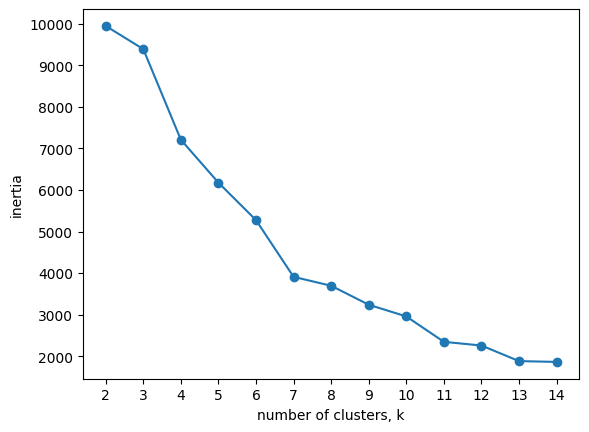

[9945.591671246135, 9388.061228248094, 7208.4705548627, 6175.319824580287, 5274.776765323166, 3910.002265796101, 3695.527262900212, 3239.305321774886, 2957.7382561065256, 2346.874092813884, 2258.28243301221, 1883.2618559647415, 1863.7039818891617]


In [6]:
ks = range(2, 15)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(df_noloc)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()
print(inertias)

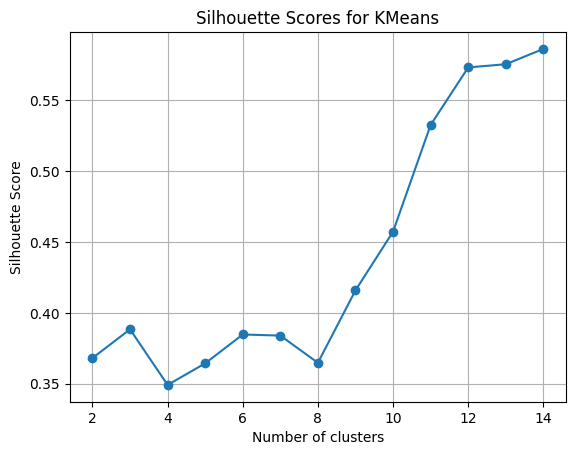

[0.36810051203424193, 0.3883894659982947, 0.349155707077625, 0.3643676623074123, 0.38475091709642223, 0.3839667823697567, 0.3647732487827086, 0.4158747893652678, 0.4573126976070093, 0.5326163812323935, 0.5732267669036385, 0.5754764583987341, 0.5862806390298335]


In [7]:
silhouette_scores = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_noloc)
    score = silhouette_score(df_noloc, labels)
    silhouette_scores.append(score)

plt.plot(range(2, 15), silhouette_scores, marker='o')
plt.title('Silhouette Scores for KMeans')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()
print(silhouette_scores)

Features shape (should be without 'Cluster'): (3453, 14)
Cluster centers shape: (8, 14)
PCA expects features: 14


D:\Python\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


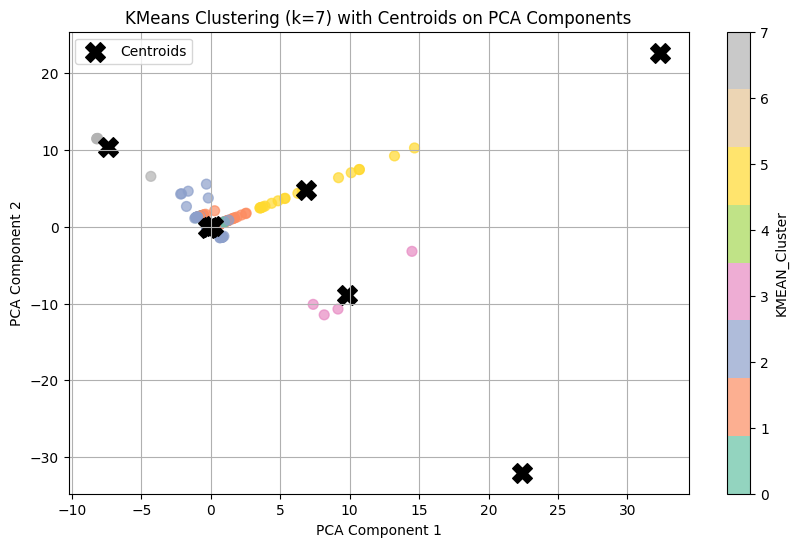

In [8]:
# K=8 chosen
# Assuming X_features is your cleaned, scaled DataFrame WITHOUT 'Cluster' column
# If not loaded yet, load your data here:
# X_features = pd.read_csv("your_cleaned_data.csv")  # update path accordingly

print(f"Features shape (should be without 'Cluster'): {df_noloc.shape}")

# Step 1: Fit PCA on features_only to reduce to 2 components
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(df_noloc)

# Step 2: Fit KMeans on the same features_only
kmeans = KMeans(n_clusters=8, random_state=42)
cluster_labels = kmeans.fit_predict(df_noloc)

# Step 3: Add cluster labels to original DataFrame
df_noloc['KMEAN_Cluster'] = cluster_labels
df_scaled['Cluster'] = cluster_labels

# Step 4: Transform cluster centers to PCA space
print(f"Cluster centers shape: {kmeans.cluster_centers_.shape}")
print(f"PCA expects features: {pca.n_features_in_}")

centroids_pca = pca.transform(kmeans.cluster_centers_)

# Step 5: Plot PCA scatter with clusters and centroids
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='Set2', s=50, alpha=0.7)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, c='black', label='Centroids')
plt.title("KMeans Clustering (k=7) with Centroids on PCA Components")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="KMEAN_Cluster")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
print("Explained variance ratio per PC:", pca.explained_variance_ratio_)
print("Total explained variance by 2 PCs:", pca.explained_variance_ratio_.sum())

sil_score = silhouette_score(df_noloc, cluster_labels)
print(f"Silhouette Score: {sil_score:.3f}")

cluster_profile = df_noloc.groupby('KMEAN_Cluster').mean()
print(cluster_profile)

Explained variance ratio per PC: [0.30349139 0.28489301]
Total explained variance by 2 PCs: 0.5883844041354362
Silhouette Score: 0.497
               Estimated Total Budget ($)  Completion_Year   
KMEAN_Cluster                                                
0                               -0.085848        -0.001334  \
1                               -0.000871         0.019495   
2                               -0.093253        -0.005029   
3                                2.978380       -12.924980   
4                               40.238438        -0.020837   
5                                8.313423        -0.020837   
6                               -0.113620       -39.124299   
7                               -0.015077        12.752961   

               Provincial Funding_Flag  Federal Funding_Flag   
KMEAN_Cluster                                                  
0                             1.000000              0.000000  \
1                             0.999194              

In [10]:
# Assume you have this:
# - kmeans_labels: your KMeans labels
# - X_features: the standardized features used for clustering (without lat/long)
# - original_df: original cleaned dataframe before scaling (to make interpretation easier)

# Step 1: Attach cluster labels to original data (use unscaled for readability)
clustered_X = df_noloc.copy()
clustered_X['KMEAN_Cluster'] = cluster_labels

# Step 2: Compute average values per cluster
cluster_summary = clustered_X.groupby('KMEAN_Cluster').mean(numeric_only=True)

# Step 3: Optional – round for readability
cluster_summary = cluster_summary.round(2)

# Step 4: Display
print(cluster_summary)

               Estimated Total Budget ($)  Completion_Year   
KMEAN_Cluster                                                
0                                   -0.09            -0.00  \
1                                   -0.00             0.02   
2                                   -0.09            -0.01   
3                                    2.98           -12.92   
4                                   40.24            -0.02   
5                                    8.31            -0.02   
6                                   -0.11           -39.12   
7                                   -0.02            12.75   

               Provincial Funding_Flag  Federal Funding_Flag   
KMEAN_Cluster                                                  
0                                 1.00                  0.00  \
1                                 1.00                  0.08   
2                                 0.98                  1.00   
3                                 1.00                  0.7

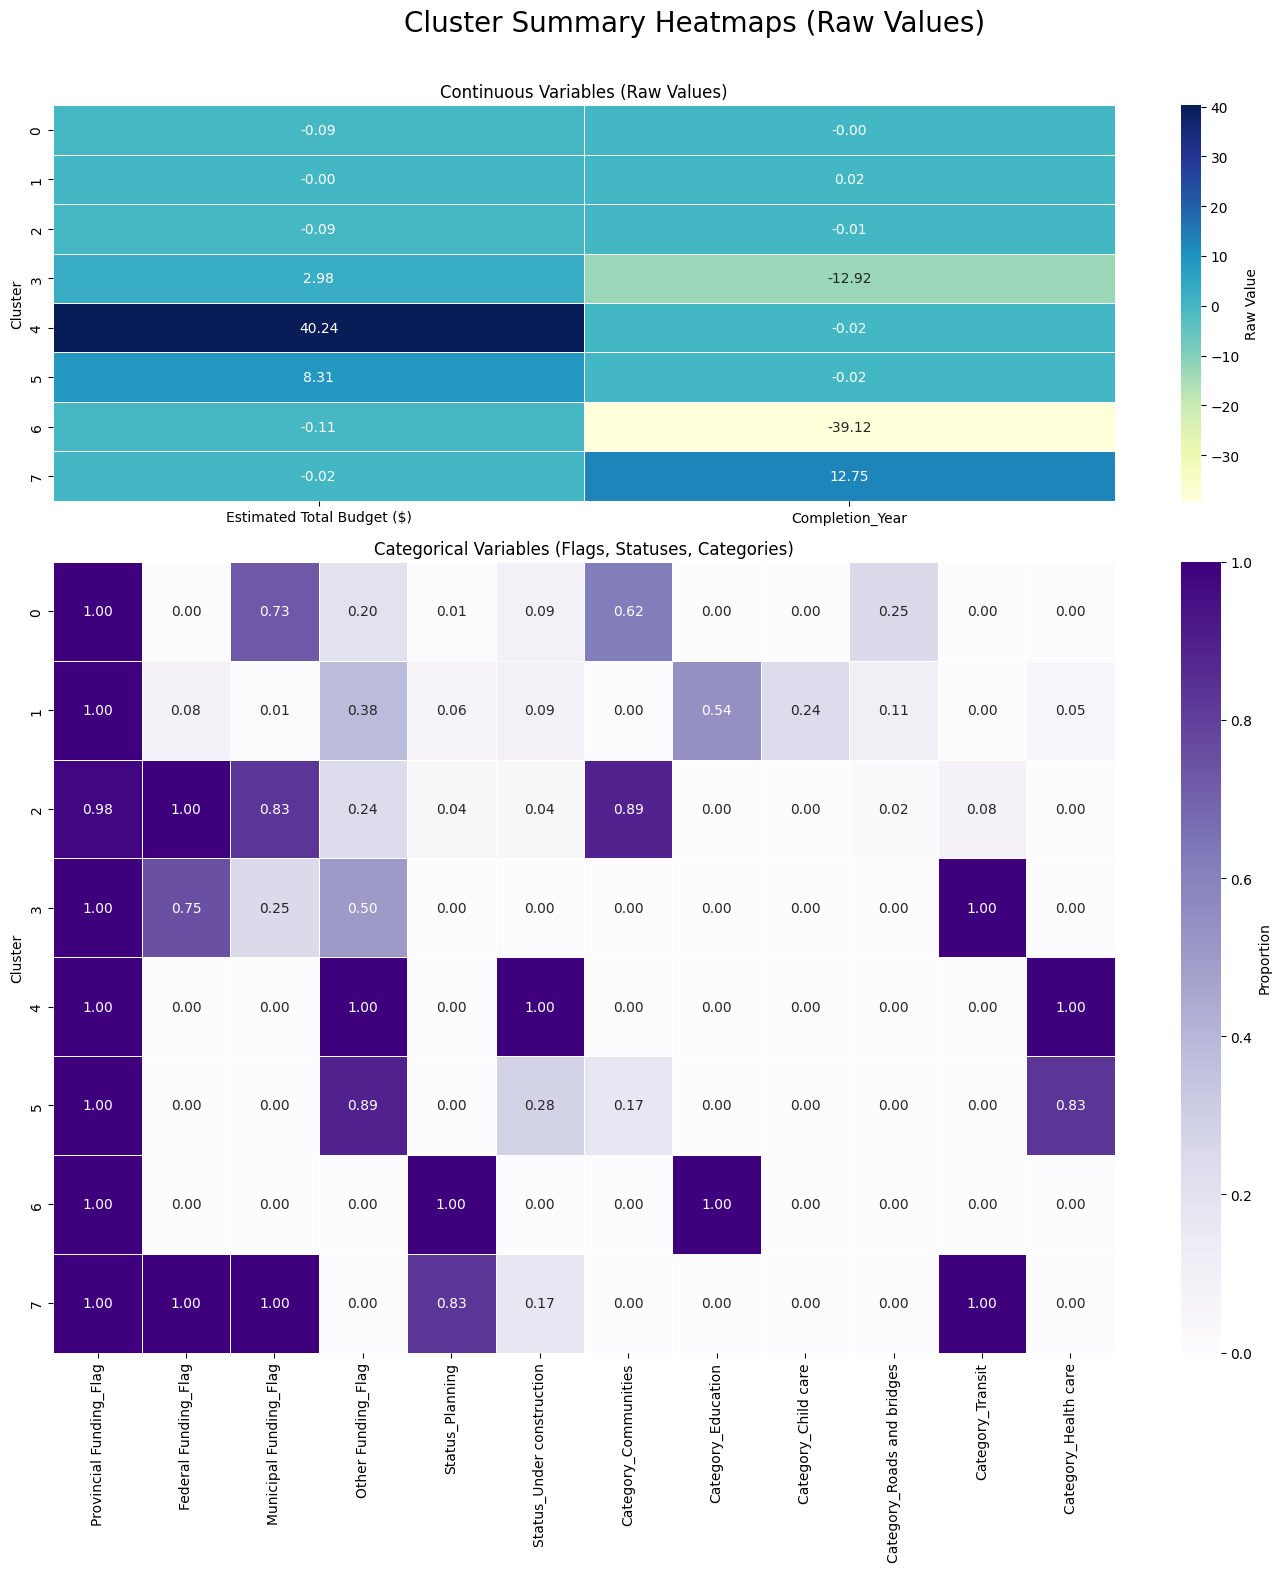

In [11]:
# 1. Remove unnecessary columns if they exist
cols_to_drop = ['_id', 'Latitude', 'Longitude']
cluster_summary_X = cluster_summary.drop(columns=[col for col in cols_to_drop if col in cluster_summary.columns])

# 2. Define expected column groups
continuous_cols = ['Estimated Total Budget ($)', 'Completion_Year']
# Categorical: Everything else in the DataFrame that's not continuous
categorical_cols = [col for col in cluster_summary_X.columns if col not in continuous_cols]

# 3. Select only the columns that actually exist in the DataFrame
continuous_cols = [col for col in continuous_cols if col in cluster_summary_X.columns]
categorical_cols = [col for col in categorical_cols if col in cluster_summary_X.columns]

# 4. Slice data
continuous_data = cluster_summary_X[continuous_cols]
categorical_data = cluster_summary_X[categorical_cols]

# 5. Plot two separate heatmaps
fig, axes = plt.subplots(2, 1, figsize=(14, 16), gridspec_kw={'height_ratios': [1, 2]})
fig.suptitle("Cluster Summary Heatmaps (Raw Values)", fontsize=20)

# Heatmap 1: Continuous features
sns.heatmap(
    continuous_data,
    cmap='YlGnBu',
    linewidths=0.5,
    annot=True,
    fmt=".2f",
    ax=axes[0],
    cbar_kws={"label": "Raw Value"}
)
axes[0].set_title("Continuous Variables (Raw Values)")
axes[0].set_ylabel("Cluster")

# Heatmap 2: Categorical-like proportions
sns.heatmap(
    categorical_data,
    cmap='Purples',
    linewidths=0.5,
    annot=True,
    fmt=".2f",
    ax=axes[1],
    cbar_kws={"label": "Proportion"}
)
axes[1].set_title("Categorical Variables (Flags, Statuses, Categories)")
axes[1].set_ylabel("Cluster")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [12]:
cluster_names = {
    0: "Local Community Projects (Municipally Funded)",
    1: "Mixed Education & Community Projects (Some Federal Support)",
    2: "Planned Education (Long-Term Horizon)",
    3: "Completed Transit Megaprojects",
    4: "Health Care Infrastructure (Category-Heavy)",
    5: "Fully Funded Community Projects (Active)",
    6: "Ongoing Large-Scale Health Projects",
    7: "Mixed/Small Projects (Low Signal)"
}
# Apply to your clustered features dataframe
df_noloc['Cluster_Name'] = df_scaled['Cluster'].map(cluster_names)

# Optionally also add to scaled dataframe
df_scaled['Cluster_Name'] = df_scaled['Cluster'].map(cluster_names)

In [13]:
import matplotlib.colors as mcolors
# 1. Base map centered around mean coordinates
map_center = [df_scaled["Latitude"].mean(), df_scaled["Longitude"].mean()]
m = folium.Map(location=map_center, zoom_start=6)

# 2. Add a marker cluster
marker_cluster = MarkerCluster().add_to(m)

# 3. Create a color map from unique cluster names
unique_clusters = df_scaled["Cluster_Name"].unique()
cmap = plt.cm.get_cmap("tab10", len(unique_clusters))  # Or use 'Set1', 'tab20', etc.

color_dict = {name: mcolors.to_hex(cmap(i)) for i, name in enumerate(unique_clusters)}

# 4. Add each point to the map with cluster color
from folium import FeatureGroup, LayerControl

# Add a group per cluster
cluster_groups = {}
for name in unique_clusters:
    cluster_groups[name] = FeatureGroup(name=name)
    m.add_child(cluster_groups[name])

# Add markers to appropriate group
for _, row in df_scaled.iterrows():
    tooltip = folium.Tooltip(f"Cluster: {row['Cluster_Name']}<br>"
                         f"Budget: {row['Estimated Total Budget ($)']:.2f}<br>"
                         f"Year: {row['Completion_Year']:.0f}")
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=5,
        color=color_dict.get(row["Cluster_Name"], "#000000"),
        fill=True,
        fill_color=color_dict.get(row["Cluster_Name"], "#000000"),
        fill_opacity=0.7,
        popup=row["Cluster_Name"],
        tooltip=tooltip
    ).add_to(cluster_groups[row["Cluster_Name"]])

m.add_child(LayerControl())


from branca.element import Element

# Build the legend HTML manually
legend_html = """
<div style="
    position: fixed; 
    bottom: 50px; left: 50px; 
    width: 200px; 
    background-color: white; 
    z-index:9999; 
    font-size:14px;
    border:2px solid grey; 
    padding: 10px;
">
    <b>Cluster Legend</b><br>
"""

for name, color in color_dict.items():
    legend_html += f"""
    <div style="margin-bottom: 5px;">
        <i style="background:{color};width:10px;height:10px;display:inline-block;margin-right:5px;"></i>{name}
    </div>
    """

legend_html += "</div>"

# Add to map using Element
legend_element = Element(legend_html)
m.get_root().html.add_child(legend_element)

# 5. Save and show the map
m.save("kmeans_cluster_map.html")
m


C:\Users\houju\AppData\Local\Temp\ipykernel_34532\993345096.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", len(unique_clusters))  # Or use 'Set1', 'tab20', etc.


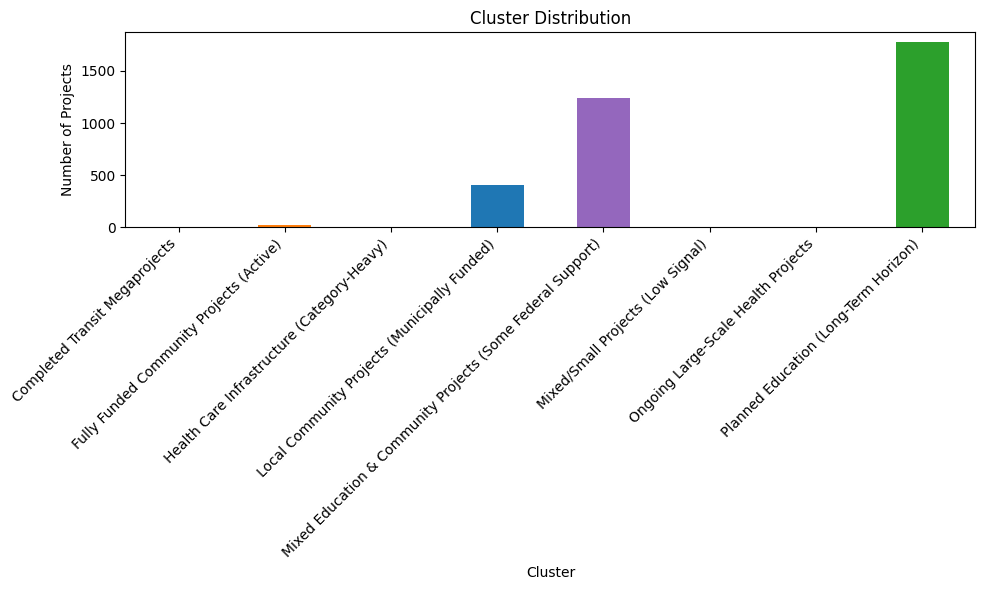

Cluster_Name
Completed Transit Megaprojects                                    4
Fully Funded Community Projects (Active)                         18
Health Care Infrastructure (Category-Heavy)                       1
Local Community Projects (Municipally Funded)                   401
Mixed Education & Community Projects (Some Federal Support)    1241
Mixed/Small Projects (Low Signal)                                 6
Ongoing Large-Scale Health Projects                               1
Planned Education (Long-Term Horizon)                          1781
Name: count, dtype: int64


In [14]:
cluster_counts = df_scaled['Cluster_Name'].value_counts().sort_index()

plt.figure(figsize=(10,6))
cluster_counts.plot(kind='bar', color=[color_dict[name] for name in cluster_counts.index])
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Projects')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print(cluster_counts)